# Figure 2 - Phase dependent P-T and chemical profiles
This Jupyter notebooks reproduces Figure 2. The output .png and .pdf files are saved in <em>/figures</em>. P-T and chemical profiles to show variation as a function of spatial location and observed phase. Profiles are shown at a latitude of 0 degree and +45 degrees for longitudes visible at the start and end orbital phase.

In [37]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from scipy.interpolate import RegularGridInterpolator
import matplotlib.gridspec as gridspec
from matplotlib import colormaps

Input directory for GCM output and elemental abundances.

In [38]:
dirin = '../data/gcm/'
dirout = '../figures/'
gcm_input_fname = 'W76b0GPF.txt'
gcm_input_file = os.path.join(dirin, gcm_input_fname)

All plotting functions and loading routines.

In [39]:
def plot_pt_chemistry(pressure, lats, phase, lat = 0., tau_CO=(0.5e-3,7.5e-3), tau_H2O=(10e-3, 150e-5), tau_cont=(10e-3, 150e-5), phase_precision=2, lat_precision=1):
    """Plot P-T chemistry."""
    cmap = colormaps['inferno']
    c1 = 'k'
    c2 = cmap(0.9)
    
    fig = plt.figure(figsize=(5.,5./1.68))
    gs = gridspec.GridSpec(nrows=1, ncols=4, width_ratios=[1.,0.5,0.5,0.5],wspace=0)
    ax = fig.add_subplot(gs[0,1])
    ax2 = fig.add_subplot(gs[0,2])
    ax3 = fig.add_subplot(gs[0,0])
    ax4 = fig.add_subplot(gs[0,3])

    is_dayside = lambda l: l <= 90. or l >= 270.
    rot = phase - 180.
    
    longs_grid = np.linspace(0, 360, 100)
    longs_masked = longs_grid[
        np.logical_or((longs_grid + rot)%360<90., (longs_grid + rot)%360>270.)
    ]
    first_day = True
    first_night = True
    profiles = np.zeros(shape=(len(pressure), len(longs_masked), 3)) * np.nan
    for lon_i, lon in enumerate(longs_masked):
        try:
            if lat == 45.:
                geometric_factor = 0.5 * np.cos(lon/180.*np.pi)
            if lat == 0.:
                geometric_factor = np.cos(lon/180.*np.pi)
            temperature = interp_T((lon, lat, pressure))
            abundance_CO = np.array([interp_eos_CO((t,p)) for (t,p) in zip(temperature,pressure)])
            abundance_H2O = np.array([interp_eos_H2O((t,p)) for (t,p) in zip(temperature,pressure)])
            
            profiles[:, lon_i, 0] = temperature
            profiles[:, lon_i, 1] = abundance_CO
            profiles[:, lon_i, 2] = abundance_H2O
            
            alpha_geo = min(max(geometric_factor+0.05, 0.05), 1.)
            if is_dayside(lon):
                if first_day:
                    ax3.annotate('day', xy=(2950,1e-3), color=c2, fontsize=12)
                    first_day = False
                ax.plot(abundance_CO, pressure, color=c2, ls='-', zorder=0, lw=2, alpha=alpha_geo)
                ax2.plot(abundance_H2O, pressure, color=c2, ls='-', zorder=0, lw=2, alpha=alpha_geo)
                ax3.plot(temperature, pressure, color=c2, ls='-', zorder=0, lw=2, alpha=alpha_geo)
            else:
                if first_night:
                    ax3.annotate('night', xy=(1000,1e0), color=c1, fontsize=12)
                    first_night = False
                ax.plot(abundance_CO, pressure, color=c1, ls='-', zorder=1, lw=2, alpha=alpha_geo)
                ax2.plot(abundance_H2O, pressure, color=c1, ls='-', zorder=1, lw=2, alpha=alpha_geo)
                ax3.plot(temperature, pressure, color=c1, ls='-', zorder=1, lw=2, alpha=alpha_geo)
        except:
            pass

    ax.set_yscale('log')
    ax2.set_yscale('log')
    ax3.set_yscale('log')

    ax.set_ylim(1e1,1e-5)
    ax2.set_ylim(1e1,1e-5)
    ax3.set_ylim(1e1,1e-5)

    ax.set_xlim(-9,-1)
    ax2.set_xlim(-9,-1)
    ax3.set_xlim(0,3750)

    ax2.set_yticklabels([])
    ax.set_yticklabels([])

    ax.set_title('CO', color='red', fontsize=12)
    ax2.set_title('H$_2$O', color='blue', fontsize=12)
    ax3.set_title('P-T profiles', color='k', fontsize=12)

    ax.set_xticks([-2,-4,-6,-8])
    ax2.set_xticks([-2,-4,-6,-8])

    ax.patch.set_facecolor('black')
    ax.patch.set_alpha(0.25)
    ax2.patch.set_facecolor('black')
    ax2.patch.set_alpha(0.25)
    ax3.patch.set_facecolor('black')
    ax3.patch.set_alpha(0.25)
    ax4.patch.set_facecolor('black')
    ax4.patch.set_alpha(0.25)
    
    data = [pressure, longs_masked, profiles, tau_CO, tau_H2O, tau_cont]

    plt.suptitle('Observed at $\phi$={:.{}f}, latitude={:+.{}f}$\degree$'.format(phase/360., phase_precision, lat, lat_precision), y=1.1, fontsize=15)
    return fig, (ax,ax2,ax3, ax4), data

def load_pt_3d(gcm_input_file):
    """Load GCM 3D P-T profile."""
    data = np.loadtxt(gcm_input_file, skiprows=6)

    longs = data[:,1]
    lats = data[:,0]
    longs = np.unique(longs)
    lats = np.unique(lats)

    pt_3d = {}
    for a, lon in enumerate(longs):
        for b, lat in enumerate(lats):
            i = np.where(np.logical_and(data[:,1] == lon, data[:,0] == lat))[0]
            P = data[i,4] 
            T = data[i,5]
            pt_3d[f'({np.round(lon,1)}, {np.round(lat,1)})'] = (P, T)
    
    return np.round(longs,1), np.round(lats,1), pt_3d

def plot_pt_3d(longs, lats, pt_3d, spacing=4):
    """Plot 3D P-T profile."""
    fig, ax = plt.subplots()
    for a, lon in enumerate(longs[::spacing]):
        for b, lat in enumerate(lats[::spacing]):
            P, T = pt_3d[f'({lon}, {lat})']
            plt.plot(T, P)
    plt.yscale('log')
    plt.ylim(1e2, 1e-5)
    return fig, ax

def load_eos(eos_input_file):
    """Load eos."""
    #reading in the chemistry file
    columns2 = ['T','P','el','H','H2','He','C2H2',
               'CH4','CO','CO2','H2O','H2S','HCN',
               'K','Na','NH3','PH3','TIO','VO',
               'Fe', 'Fe+', 'Mg', 'Ca', 'Ti', 'Ti+',
               'V', 'C', 'Cr', 'Ni','Mn','Ca+','Li', 'OH']

    df2 = pd.read_csv(eos_input_file, names=columns2,skiprows=1,delim_whitespace=True).dropna()

    """Load equilibrium chemistry VMR values."""
    #makind some arrays to hold values for each pressure (28) and temperature (46)
    eosH2Ovals=np.zeros((28,46))
    eosCOvals=np.zeros((28,46))
    #eosOHvals=np.zeros((28,46))

    tempvalues=np.linspace(500,5000,num=46,endpoint=True) #grid of temperature values
    pressures=[1.00000000e-06, 2.15443452e-06, 4.64158919e-06, 1.00000000e-05,
     2.15443452e-05, 4.64158919e-05, 1.00000000e-04, 2.15443304e-04,
     4.64159240e-04, 1.00000000e-03, 2.15443304e-03, 4.64159240e-03,
     1.00000000e-02, 2.15443304e-02, 4.64159240e-02, 1.00000000e-01,
     2.15443304e-01, 4.64159240e-01, 1.00000000e+00, 2.15443304e+00,
     4.64159240e+00, 1.00000000e+01, 2.15443304e+01, 4.64159240e+01,
     1.00000000e+02, 2.15443304e+02, 4.64159240e+02, 1.00000000e+03] #grid of pressure values

    tempcount=0
    presscount=0
    for i in range(1288):
        if tempcount < 46 and presscount < 28:
            eosH2Ovals[presscount,tempcount]=df2['H2O'].iloc[i]
            eosCOvals[presscount,tempcount]=df2['CO'].iloc[i]
            tempcount=tempcount+1
        elif presscount < 28:
            tempcount=0
            presscount=presscount+1
            eosH2Ovals[presscount,tempcount]=df2['H2O'].iloc[i]
            eosCOvals[presscount,tempcount]=df2['CO'].iloc[i]
            tempcount=tempcount+1

    #need to reverse the temperature values to match the order of the opacity files
    #and then reverse the pressure order 
    for j in range(28):
        eosH2Ovals[j,:]=eosH2Ovals[j,::-1]
        eosCOvals[j,:]=eosCOvals[j,::-1]
        #eosOHvals[j,:]=eosOHvals[j,::-1]
    for p in range(46):
        eosH2Ovals[:,p]=eosH2Ovals[::-1,p]
        eosCOvals[:,p]=eosCOvals[::-1,p]
        
    return tempvalues, pressures, eosCOvals, eosH2Ovals

Load set of phase-dependent P-T profiles.

In [40]:
longs, lats, pt_3d = load_pt_3d(gcm_input_file)
nlon, nlat = len(longs), len(lats)
nP = 100
P = 10**np.linspace(-6, 2, nP)
T = np.zeros(shape=(nlon, nlat, nP))
for a, lon in enumerate(longs):
    for b, lat in enumerate(lats):
        pressure, temperature = pt_3d[f'({lon}, {lat})']
        T[a,b,:] = np.interp(x=P, xp=pressure, fp=temperature)
interp_T = RegularGridInterpolator((longs, lats, P), T, bounds_error=False)

Compute chemical profiles from the P-T profiles.

In [41]:
eos_input_fname = 'eos_solar_gas_full_hires.dat'
eos_input_file = os.path.join(dirin, eos_input_fname)

T_eos, P_eos, eosCOvals, eosH2Ovals = load_eos(eos_input_file)

interp_eos_CO = RegularGridInterpolator((T_eos, P_eos), np.log10(eosCOvals.T), bounds_error=False)
interp_eos_H2O = RegularGridInterpolator((T_eos, P_eos), np.log10(eosH2Ovals.T))

Create all four panels of Figure 2.

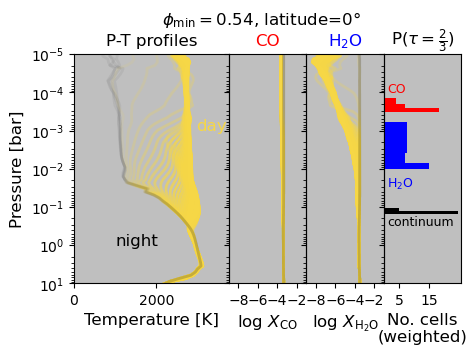

In [42]:
phase = 360. * 0.54
lat = 0.
fig, axes, data = plot_pt_chemistry(P, lats, lat=0., phase=phase,
                                    tau_CO=(10**-3.89, 10**-3.49),
                                    tau_H2O=(10**-3.27, 10**-1.98),
                                    tau_cont=(10**-1.12, 10**-0.82),
                                    phase_precision=1, lat_precision=0)
fig.suptitle(r'$\phi_{\rm{min}}=0.54$, latitude=$0\degree$', y = 1.03)
pickle.dump(data, open(dirin+f'gcm_pt_and_chemistry_{phase:.2f}_{lat:.2f}.pic', 'wb'))

# Added panel for revision
phase = 195
_, _, tau_CO = pickle.load(open(f'../data/gcm/tau_2_3_map_{phase}_CO', 'rb'))
_, _, tau_H2O = pickle.load(open(f'../data/gcm/tau_2_3_map_{phase}_H2O', 'rb'))
_, _, tau_cont = pickle.load(open(f'../data/gcm/tau_2_3_map_{phase}_continuum', 'rb'))
nlat, nlon_vis = tau_CO.shape
lon_vis_min = phase-90.
lon_vis_max = phase+90.
lon_vis = np.linspace(lon_vis_min, lon_vis_max, nlon_vis)
geometric_factor = np.cos((lon_vis-180.)/180.*np.pi)
n_equator = int(0.5*nlat)
plt.hist(tau_CO[n_equator, :]/1e5, bins=3, weights=geometric_factor, orientation='horizontal', color='red')
plt.hist(tau_H2O[n_equator, :]/1e5, bins=3, weights=geometric_factor, orientation='horizontal', color='blue')
plt.hist(tau_cont[n_equator, :]/1e5, bins=3, weights=geometric_factor, orientation='horizontal', color='black')

axes[3].set_title(r'P($\tau=\frac{2}{3})$', size=12)
axes[3].set_yscale('log')
axes[3].set_ylim(1e1,1e-5)
axes[3].set_xlim(0,)
axes[3].set_xticks([5,15])
axes[3].set_xticklabels([5,15])
axes[3].set_yticklabels([])
axes[3].set_xlabel('No. cells\n(weighted)', size=12)

axes[0].set_xlabel(r'log $X_{\rm{CO}}$', size=12)
axes[1].set_xlabel(r'log $X_{\rm{H_2O}}$', size=12)
axes[2].set_xlabel('Temperature [K]', size=12)
axes[2].set_ylabel('Pressure [bar]', size=12)

axes[3].annotate('continuum', xy=(1, 0.3), fontsize=9)
axes[3].annotate(r'H$_2$O', xy=(1, 3e-2), fontsize=9, color='blue')
axes[3].annotate('CO', xy=(1, 1e-4), fontsize=9, color='red')

plt.savefig(dirout+f'Fig2_Panel1_phase_dependent_p_t_and_chemical_profiles.png', dpi=250, bbox_inches='tight')
plt.savefig(dirout+f'Fig2_Panel1_phase_dependent_p_t_and_chemical_profiles.pdf', bbox_inches='tight')
plt.show()

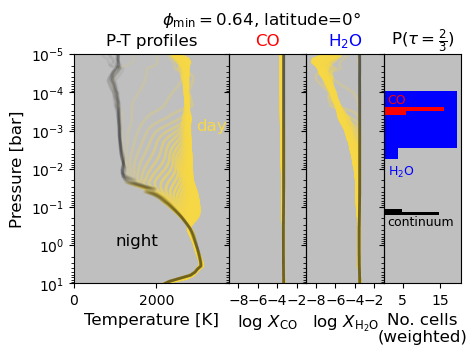

In [43]:
phase = 360*0.64
lat = 0.
fig, axes, data = plot_pt_chemistry(P, lats, lat=0., phase=phase,
                                    tau_CO=(10**-4.07, 10**-3.10),
                                    tau_H2O=(10**-4.08, 10**-2.09),
                                    tau_cont=(10**-1.12, 10**-0.75),
                              phase_precision=1, lat_precision=0)
pickle.dump(data, open(dirin+f'gcm_pt_and_chemistry_{phase:.2f}_{lat:.2f}.pic', 'wb'))

# Added panel for revision
phase = 232.5
_, _, tau_CO = pickle.load(open(f'../data/gcm/tau_2_3_map_{phase}_CO', 'rb'))
_, _, tau_H2O = pickle.load(open(f'../data/gcm/tau_2_3_map_{phase}_H2O', 'rb'))
_, _, tau_cont = pickle.load(open(f'../data/gcm/tau_2_3_map_{phase}_continuum', 'rb'))
nlat, nlon_vis = tau_CO.shape
lon_vis_min = phase-90.
lon_vis_max = phase+90.
lon_vis = np.linspace(lon_vis_min, lon_vis_max, nlon_vis)
geometric_factor = np.cos((lon_vis-180.)/180.*np.pi)
plt.hist(tau_H2O[n_equator, :]/1e5, bins=3, weights=geometric_factor, orientation='horizontal', color='blue')
plt.hist(tau_CO[n_equator, :]/1e5, bins=3, weights=geometric_factor, orientation='horizontal', color='red')
plt.hist(tau_cont[n_equator, :]/1e5, bins=3, weights=geometric_factor, orientation='horizontal', color='black')
axes[3].set_title(r'P($\tau=\frac{2}{3})$', size=12)
axes[3].set_yscale('log')
axes[3].set_ylim(1e1,1e-5)
axes[3].set_xlim(0,)
axes[3].set_xticks([5,15])
axes[3].set_xticklabels([5,15])
axes[3].set_yticklabels([])
axes[3].set_xlabel('No. cells\n(weighted)', size=12)



fig.suptitle(r'$\phi_{\rm{min}}=0.64$, latitude=$0\degree$', y = 1.03)
axes[0].set_xlabel(r'log $X_{\rm{CO}}$', size=12)
axes[1].set_xlabel(r'log $X_{\rm{H_2O}}$', size=12)
axes[2].set_xlabel('Temperature [K]', size=12)
axes[2].set_ylabel('Pressure [bar]', size=12)

axes[3].annotate('continuum', xy=(1, 0.3), fontsize=9)
axes[3].annotate(r'H$_2$O', xy=(1, 1.5e-2), fontsize=9, color='blue')
axes[3].annotate('CO', xy=(1, 2e-4), fontsize=9, color='red')

plt.savefig(dirout+f'Fig2_Panel2_phase_dependent_p_t_and_chemical_profiles.png', dpi=250, bbox_inches='tight')
plt.savefig(dirout+f'Fig2_Panel2_phase_dependent_p_t_and_chemical_profiles.pdf', bbox_inches='tight')
plt.show()

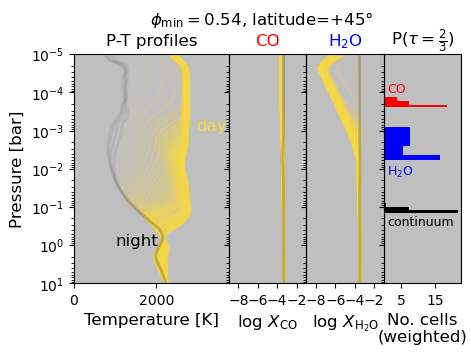

In [44]:
phase = 360*0.54
lat = 45.
n_equator = int(0.75*nlat)
fig, axes, data = plot_pt_chemistry(pressure=pressure, lats=lats, phase=phase, lat=45,
                                    tau_CO=(10**-3.89, 10**-3.49),
                                    tau_H2O=(10**-3.27, 10**-1.98),
                                    tau_cont=(10**-1.12, 10**-0.82),
                             phase_precision=1, lat_precision=0)

phase = 195
_, _, tau_CO = pickle.load(open(f'../data/gcm/tau_2_3_map_{phase}_CO', 'rb'))
_, _, tau_H2O = pickle.load(open(f'../data/gcm/tau_2_3_map_{phase}_H2O', 'rb'))
_, _, tau_cont = pickle.load(open(f'../data/gcm/tau_2_3_map_{phase}_continuum', 'rb'))
nlat, nlon_vis = tau_CO.shape
lon_vis_min = phase-90.
lon_vis_max = phase+90.
lon_vis = np.linspace(lon_vis_min, lon_vis_max, nlon_vis)
geometric_factor = np.cos((lon_vis-180.)/180.*np.pi)
plt.hist(tau_H2O[n_equator, :]/1e5, bins=3, weights=geometric_factor, orientation='horizontal', color='blue')
plt.hist(tau_CO[n_equator, :]/1e5, bins=3, weights=geometric_factor, orientation='horizontal', color='red')
plt.hist(tau_cont[n_equator, :]/1e5, bins=3, weights=geometric_factor, orientation='horizontal', color='black')
axes[3].set_title(r'P($\tau=\frac{2}{3})$', size=12)
axes[3].set_yscale('log')
axes[3].set_ylim(1e1,1e-5)
axes[3].set_xlim(0,)
axes[3].set_xticks([5,15])
axes[3].set_xticklabels([5,15])
axes[3].set_yticklabels([])
axes[3].set_xlabel('No. cells\n(weighted)', size=12)

axes[3].annotate('continuum', xy=(1, 0.3), fontsize=9)
axes[3].annotate(r'H$_2$O', xy=(1, 1.5e-2), fontsize=9, color='blue')
axes[3].annotate('CO', xy=(1, 1e-4), fontsize=9, color='red')


fig.suptitle(r'$\phi_{\rm{min}}=0.54$, latitude=$+45\degree$', y = 1.03)
pickle.dump(data, open(dirin+f'gcm_pt_and_chemistry_{phase:.2f}_{lat:.2f}.pic', 'wb'))
axes[0].set_xlabel(r'log $X_{\rm{CO}}$', size=12)
axes[1].set_xlabel(r'log $X_{\rm{H_2O}}$', size=12)
axes[2].set_xlabel('Temperature [K]', size=12)
axes[2].set_ylabel('Pressure [bar]', size=12)
plt.savefig(dirout+f'Fig2_Panel3_phase_dependent_p_t_and_chemical_profiles.png', dpi=250, bbox_inches='tight')
plt.savefig(dirout+f'Fig2_Panel3_phase_dependent_p_t_and_chemical_profiles.pdf', bbox_inches='tight')
plt.show()

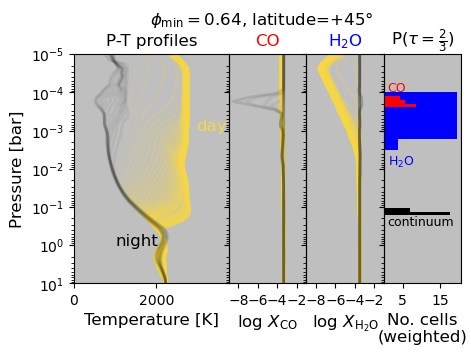

In [45]:
phase = 360*0.64
lat = 45.
fig, axes, data = plot_pt_chemistry(pressure=pressure, lats=lats, phase=phase, lat=45,
                                    tau_CO=(10**-3.89, 10**-3.49),
                                    tau_H2O=(10**-3.27, 10**-1.98),
                                    tau_cont=(10**-1.12, 10**-0.82),
                             phase_precision=1, lat_precision=0)

phase = 232.5
_, _, tau_CO = pickle.load(open(f'../data/gcm/tau_2_3_map_{phase}_CO', 'rb'))
_, _, tau_H2O = pickle.load(open(f'../data/gcm/tau_2_3_map_{phase}_H2O', 'rb'))
_, _, tau_cont = pickle.load(open(f'../data/gcm/tau_2_3_map_{phase}_continuum', 'rb'))
nlat, nlon_vis = tau_CO.shape
lon_vis_min = phase-90.
lon_vis_max = phase+90.
lon_vis = np.linspace(lon_vis_min, lon_vis_max, nlon_vis)
geometric_factor = np.cos((lon_vis-180.)/180.*np.pi)
plt.hist(tau_H2O[n_equator, :]/1e5, bins=3, weights=geometric_factor, orientation='horizontal', color='blue')
plt.hist(tau_CO[n_equator, :]/1e5, bins=3, weights=geometric_factor, orientation='horizontal', color='red')
plt.hist(tau_cont[n_equator, :]/1e5, bins=3, weights=geometric_factor, orientation='horizontal', color='black')
axes[3].set_title(r'P($\tau=\frac{2}{3})$', size=12)
axes[3].set_yscale('log')
axes[3].set_ylim(1e1,1e-5)
axes[3].set_xlim(0,)
axes[3].set_xticks([5,15])
axes[3].set_xticklabels([5,15])
axes[3].set_yticklabels([])
axes[3].set_xlabel('No. cells\n(weighted)', size=12)

axes[3].annotate('continuum', xy=(1, 0.3), fontsize=9)
axes[3].annotate(r'H$_2$O', xy=(1, 0.8e-2), fontsize=9, color='blue')
axes[3].annotate('CO', xy=(1, 0.95e-4), fontsize=9, color='red')

fig.suptitle(r'$\phi_{\rm{min}}=0.64$, latitude=$+45\degree$', y = 1.03)
pickle.dump(data, open(dirin+f'gcm_pt_and_chemistry_{phase:.2f}_{lat:.2f}.pic', 'wb'))
axes[0].set_xlabel(r'log $X_{\rm{CO}}$', size=12)
axes[1].set_xlabel(r'log $X_{\rm{H_2O}}$', size=12)
axes[2].set_xlabel('Temperature [K]', size=12)
axes[2].set_ylabel('Pressure [bar]', size=12)
plt.savefig(dirout+f'Fig2_Panel4_phase_dependent_p_t_and_chemical_profiles.png', dpi=250, bbox_inches='tight')
plt.savefig(dirout+f'Fig2_Panel4_phase_dependent_p_t_and_chemical_profiles.pdf', bbox_inches='tight')
plt.show()